In [1]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
from scipy import sparse
import scipy


import sys
sys.path.append('..')

In [2]:
L = 6

Sz = np.zeros([2,2])
Sz[0,0] = 1/2
Sz[1,1] = -1/2
Sx = np.zeros([2,2])
Sx[1,0] = 1/2
Sx[0,1] = 1/2
Sy = np.zeros([2,2], dtype=np.complex64)
Sy[1,0] = 1j/2
Sy[0,1] = -1j/2


SzSz = np.kron(Sz,Sz).astype(np.float64)
SxSx = np.kron(Sx,Sx).astype(np.float64)
SySy = np.kron(Sy,Sy).astype(np.float64)

lh = SzSz + SxSx + SySy

/Users/keisukemurota/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


### exact diagonalization with original matrix

In [3]:
import functions as f
from importlib import reload
from scipy import sparse
import scipy.sparse.linalg
import scipy
reload(f)

H = sparse.csr_matrix((2**L, 2**L), dtype=np.float64)
for i in range(L):
    
    H += f.l2nl(lh, L, [i,(i+1)%L], sps = 2)
    H += f.l2nl(lh/2, L, [i,(i+2)%L], sps = 2)   

E, V = np.linalg.eigh(H.toarray())
print(E)

[-2.25000000e+00 -2.25000000e+00 -1.75000000e+00 -1.75000000e+00
 -1.75000000e+00 -1.56872930e+00 -1.56872930e+00 -1.56872930e+00
 -1.56872930e+00 -1.56872930e+00 -1.56872930e+00 -1.25000000e+00
 -1.25000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -2.50000000e-01
 -2.50000000e-01 -2.50000000e-01 -2.50000000e-01 -2.50000000e-01
 -2.50000000e-01 -5.30516917e-16 -4.91759089e-16 -3.05973681e-16
 -9.62409177e-17 -7.01392900e-17  1.16958990e-16  2.24511772e-16
  3.25195482e-16  4.63662579e-16  5.11587843e-16  2.50000000e-01
  2.50000000e-01  2.50000000e-01  2.50000000e-01  2.50000000e-01
  2.50000000e-01  3.18729304e-01  3.18729304e-01  3.18729304e-01
  3.18729304e-01  3.18729304e-01  3.18729304e-01  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  2.25000000e+00  2.25000000e+00  2.25000000e+00
  2.25000000e+00  2.25000

/Users/keisukemurota/miniconda3/envs/research/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### rewritten with projection operators

In [4]:
LH = sparse.csr_matrix((2**3,2**3), dtype = np.float64)
i = 0
LH += f.l2nl(lh/2, 3, [i,(i+1)%L], sps = 2)
LH += f.l2nl(lh/2, 3, [(i+1)%L,(i+2)%L], sps = 2)
LH += f.l2nl(lh/2, 3, [i,(i+2)%L], sps = 2) 
LH = LH

In [5]:
sparse.kron

<function scipy.sparse.construct.kron(A, B, format=None)>

In [6]:
LH_ = sparse.csr_matrix((2**3,2**3), dtype = np.float64)
i = 0
LH_ += f.l2nl(lh/2, 3, [0, 1], sps = 2)
LH_ += f.l2nl(lh/2, 3, [0, 2], sps = 2)
LH_ += f.l2nl(lh/2, 3, [1, 2], sps = 2)



LH = sparse.csr_matrix((2**6,2**6), dtype = np.float64)
LH += f.l2nl(LH_/2, 6, [0, 1, 2], sps = 2)
LH += f.l2nl(LH_, 6, [1, 2, 3], sps = 2)
LH += f.l2nl(LH_, 6, [2, 3, 4], sps = 2)
LH += f.l2nl(LH_/2, 6, [3, 4, 5], sps = 2)

H = sparse.csr_matrix((2**6,2**6), dtype = np.float64)
H += f.l2nl(LH, 2, [0, 1], sps = 8)
H += f.l2nl(LH, 2, [1, 0], sps = 8)

In [7]:
# X = -LH.toarray()
X = -H.toarray()
X -= np.eye(X.shape[0]) * np.min(np.diag(X))

### dual annealing

In [277]:
def callbackF(x, f, context):
    print("target value : {:.5f} in the context {}".format(f,context))

In [278]:
from utils import optm
reload(optm)
# X = np.stack([X1_prime, X2_prime])
func = optm.unitary_optm(X)
import scipy.optimize as optimize
bounds = [[0, 2*np.pi] for _ in range(28)]
ret = optimize.dual_annealing(func, bounds = bounds, restart_temp_ratio = 1e-5, visit = 2.7, initial_temp = 3*10**4, maxiter = 10000, callback = callbackF)
print(ret)

[28]
target value : 8.23302 in the context 0
target value : 8.20846 in the context 0
target value : 5.27296 in the context 1
target value : 5.01482 in the context 1
target value : 4.95501 in the context 1
target value : 4.94975 in the context 1
target value : 4.94604 in the context 1
target value : 4.94409 in the context 1
target value : 4.94408 in the context 1
target value : 4.94352 in the context 1
     fun: 4.943524177271737
 message: ['Maximum number of iteration reached']
    nfev: 1459443
    nhev: 0
     nit: 10000
    njev: 31015
  status: 0
 success: True
       x: array([4.75 , 0.729, 6.007, 5.32 , 0.197, 3.201, 0.831, 5.672, 6.28 ,
       0.881, 0.174, 1.327, 0.   , 5.26 , 5.943, 5.071, 4.333, 5.71 ,
       4.543, 6.016, 0.509, 6.283, 1.608, 1.083, 6.283, 4.471, 0.   ,
       4.858])


### gradient descent

In [276]:
reload(optm)
import torch.optim
model, gl = optm.optim_matrix_symm([torch.tensor(X)], 10000, optm_method = torch.optim.SGD, seed = 10, lr = 0.001, init_params=model._params)

/Users/keisukemurota/Documents/todo/worms/python/nsp/utils/optm.py:440: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model._params = torch.nn.Parameter(torch.tensor(init_params))


target loss : 4.500

---------- iteration start ----------
iteration :    0   loss : 5.138
iteration : 1000   loss : 5.139
iteration : 2000   loss : 5.139
iteration : 3000   loss : 5.139
iteration : 4000   loss : 5.138
iteration : 5000   loss : 5.139
iteration : 6000   loss : 5.139
iteration : 7000   loss : 5.139
iteration : 8000   loss : 5.139
iteration : 9000   loss : 5.139

 -------------- results --------------
target loss      : 4.5000000000
loss before optm : 5.6236516671
loss after optm  : 5.1384372930


In [275]:
np.linalg.eigvalsh(X)

array([-6.745e-16,  0.000e+00,  0.000e+00,  1.242e-17,  2.742e-17,
        3.264e-17,  3.195e-16,  1.250e+00,  1.250e+00,  1.250e+00,
        1.250e+00,  1.250e+00,  1.250e+00,  1.250e+00,  1.250e+00,
        1.250e+00,  1.250e+00,  1.931e+00,  1.931e+00,  1.931e+00,
        1.931e+00,  1.931e+00,  1.931e+00,  2.000e+00,  2.000e+00,
        2.000e+00,  2.000e+00,  2.000e+00,  2.000e+00,  2.250e+00,
        2.250e+00,  2.250e+00,  2.250e+00,  2.250e+00,  2.250e+00,
        2.250e+00,  2.250e+00,  2.250e+00,  2.250e+00,  2.500e+00,
        2.500e+00,  2.500e+00,  2.500e+00,  2.500e+00,  2.500e+00,
        3.250e+00,  3.250e+00,  3.250e+00,  3.250e+00,  3.250e+00,
        3.250e+00,  3.500e+00,  3.500e+00,  3.819e+00,  3.819e+00,
        3.819e+00,  3.819e+00,  3.819e+00,  3.819e+00,  4.000e+00,
        4.000e+00,  4.000e+00,  4.500e+00,  4.500e+00])

In [112]:
reload(optm)
import torch.optim
model, gl = optm.optim_matrix_symm([torch.tensor(X)], 10000, optm_method = torch.optim.SGD, loss_func=optm.loss_1 , seed = 10, lr = 0.00001, init_params=model._params)

target loss : 2.250

---------- iteration start ----------
iteration :    0   loss : 20.031
iteration : 1000   loss : 19.706
iteration : 2000   loss : 19.703
iteration : 3000   loss : 19.699
iteration : 4000   loss : 19.704
iteration : 5000   loss : 19.699
iteration : 6000   loss : 19.701
iteration : 7000   loss : 19.707
iteration : 8000   loss : 19.705
iteration : 9000   loss : 19.702

 -------------- results --------------
target loss      : 2.2500000000
loss before optm : 2.8182674076
loss after optm  : 2.6929198104


### another cost function

minimize $\langle \psi ^ + \vert H^+ \vert \psi ^ + \rangle$ 

In [268]:
X_prime = torch.tensor(X)
X_prime = X_prime[None, :, :]

/Users/keisukemurota/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [247]:
reload(optm)
solver = optm.unitary_solver2(X, [8,8], True)

In [248]:
for t in range(10**4):
    optimizer = torch.optim.SGD(solver.parameters(), lr = 0.001)
    M, V = solver()
    loss_ = optm.loss_2(M,V)
    optimizer.zero_grad()
    loss_.backward()
    if (t % 1000) == 0:
        print("iteration : {:4d}   loss : {:.3f}".format(t,loss_.item()))
    optimizer.step()

iteration :    0   loss : 17.725
iteration : 1000   loss : 11.772
iteration : 2000   loss : 11.426
iteration : 3000   loss : 11.365
iteration : 4000   loss : 11.361
iteration : 5000   loss : 11.359
iteration : 6000   loss : 11.357
iteration : 7000   loss : 11.357
iteration : 8000   loss : 11.357
iteration : 9000   loss : 11.358


## test several optimization scheme

$\lambda_i$ is the eigenvalues of $(UHU^T)^+$
$$
E = \max(\lambda_i) \\
w_{k+1} = w_k - \alpha \cdot \gamma \cdot \text{sign}(\partial E / \partial w_k)
$$

In [226]:
from utils import optm_method as optmm
reload(optm)
reload(optmm)

<module 'utils.optm_method' from '/Users/keisukemurota/Documents/todo/worms/python/nsp/utils/optm_method.py'>

In [147]:
N = 10**5
10**(np.log10(0.01)/N)

0.9999539493585035

In [149]:
reload(optm)
import torch.optim
model, gl = optm.optim_matrix_symm(
        [torch.tensor(X)],
        40000, 
        optm_method = optm.scheme1, 
        seed = 10,
        gamma = 0.0001,
        r = 1,
        )

target loss : 4.500
loss before optm : 5.6236516671

---------- iteration start ----------
iteration :        0   loss : 8.868	gamma = 0.0001
iteration :     1000   loss : 8.278	gamma = 0.0001
iteration :     2000   loss : 7.840	gamma = 0.0001
iteration :     3000   loss : 7.414	gamma = 0.0001
iteration :     4000   loss : 7.099	gamma = 0.0001
iteration :     5000   loss : 6.848	gamma = 0.0001
iteration :     6000   loss : 6.494	gamma = 0.0001
iteration :     7000   loss : 5.841	gamma = 0.0001
iteration :     8000   loss : 5.349	gamma = 0.0001
iteration :     9000   loss : 5.249	gamma = 0.0001
iteration :    10000   loss : 5.230	gamma = 0.0001
iteration :    11000   loss : 5.224	gamma = 0.0001
iteration :    12000   loss : 5.123	gamma = 0.0001
iteration :    13000   loss : 4.894	gamma = 0.0001
iteration :    14000   loss : 4.778	gamma = 0.0001
iteration :    15000   loss : 4.765	gamma = 0.0001
iteration :    16000   loss : 4.762	gamma = 0.0001
iteration :    17000   loss : 4.762	gamma 

## gridsearch revisit

In [272]:
from utils import optm
from utils import optm_method as optmm
reload(optm)
reload(optmm)

<module 'utils.optm_method' from '/Users/keisukemurota/Documents/todo/worms/python/nsp/utils/optm_method.py'>

In [279]:
n_index = 4
ranges = (slice(-10, 10), ) * n_index
index = np.random.choice(28, n_index, replace=True)
grid = optm.unitary_optm(X, 28, index=index, init_param = np.array(model._params.data))

In [280]:
import scipy.optimize

for _ in range(100):
    resbrute = scipy.optimize.brute(grid, ranges = ranges, full_output=True)
    index = np.random.choice(28, n_index , replace=True)
#     print(resbrute[0])
    print("target {:.4f}".format(resbrute[1]))
#     print(grid.params)
    grid = optm.unitary_optm(X, 28, index=index, init_param = grid.params)

KeyboardInterrupt: 

In [127]:
index

array([ 9, 21,  1])

In [254]:
grid([0])

4.761640719693298

In [257]:
T = np.linspace(-100,100, 1000)
y = []
grid = optm.unitary_optm(X, 28, index=index, init_param = np.array(model._params.data))
for t in T:
    y.append(grid([t*np.pi+250]))

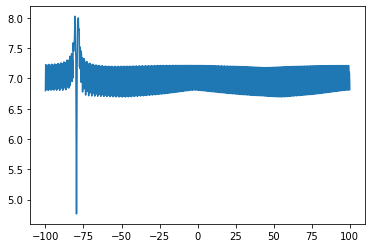

In [258]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(T,y)

In [194]:
grid.params[grid.index]

array([248630.97], dtype=float32)

In [68]:
resbrute

array([4.34404299e+00, 5.78362881e-04, 3.21762196e+00])

In [199]:
np.linalg.eigvalsh(grid.generators[0])

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])